<a href="https://colab.research.google.com/github/oktaviacitra/classification/blob/main/StrokePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read File CSV

In [ ]:
from google.colab import drive

origin_path = "/content/drive"
drive.mount(origin_path)

Mounted at /content/drive


In [ ]:
import pandas as pd

folder_path = origin_path + "/MyDrive/Learning Journey/Stroke Data"
dataset_path = folder_path + "/full_data.csv"
dataframe = pd.read_csv(dataset_path)
dataframe.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1


# Preprocessing Data

In [ ]:
categorical_columns = ['gender', 'ever_married', 'Residence_type',
                       'work_type', 'smoking_status']
for column in categorical_columns:
  dataframe[column] = pd.factorize(dataframe[column])[0]

In [ ]:
from sklearn.preprocessing import StandardScaler

value_columns = ['age', 'avg_glucose_level', 'bmi']
dataframe[value_columns] = StandardScaler().fit_transform(dataframe[value_columns])
dataframe.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,1.040584,0,1,0,0,0,2.723411,1.193238,0,1
1,0,1.614270,0,1,0,0,1,-0.000523,0.589390,1,1
2,1,0.246250,0,0,0,0,0,1.448529,0.869222,2,1


# Change 'Unknown' with specific value in column 'smoking_status'

In [ ]:
# ss means smoking_status
unknown_ss_indices = dataframe.index[dataframe['smoking_status'] == 3].tolist()
unknown_ss_dataframe = dataframe.iloc[unknown_ss_indices]
known_ss_dataframe = dataframe.copy()
known_ss_dataframe.drop(unknown_ss_indices, inplace=True)
unknown_ss_dataframe.shape, known_ss_dataframe.shape

((1500, 11), (3481, 11))

In [ ]:
unknown_ss_dataframe.drop(['smoking_status'], axis=1)
X_unknown = unknown_ss_dataframe.to_numpy()

y_known = known_ss_dataframe['smoking_status']
known_ss_dataframe.drop(['smoking_status'], axis=1)
X_known = known_ss_dataframe.to_numpy()

X_known.shape, y_known.shape, X_unknown.shape

((3481, 11), (3481,), (1500, 11))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

classifier = DecisionTreeClassifier().fit(X_known, y_known)
y_unknown = classifier.predict(X_unknown)

dataframe.loc[unknown_ss_indices,['smoking_status']] = y_unknown

# Split data

In [ ]:
X = dataframe.copy()
X.drop(['stroke'], axis=1)

y = dataframe['stroke']

X, y = X.to_numpy(), y.to_numpy()
X.shape, y.shape

((4981, 11), (4981,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((3486, 11), (1495, 11))

# Predict Stroke

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
 
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
grid.fit(X_train, y_train)
grid.best_params_, grid.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.951 total time=   0.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.951 total time=   0.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.951 total time=   0.6s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.951 total time=   0.5s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.951 total time=   0.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.987 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.987 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.987 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.986 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.986 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.951 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

({'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}, SVC(C=1, gamma=0.1))

# Evaluation

In [ ]:
from sklearn.metrics import classification_report

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1417
           1       1.00      0.97      0.99        78

    accuracy                           1.00      1495
   macro avg       1.00      0.99      0.99      1495
weighted avg       1.00      1.00      1.00      1495



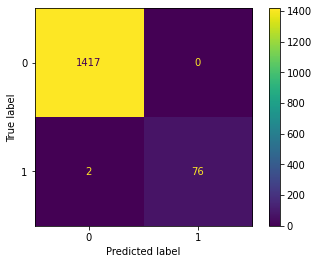

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
disp.plot()